# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

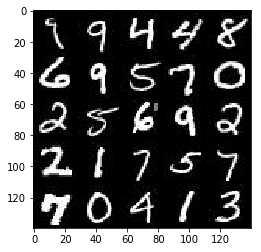

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

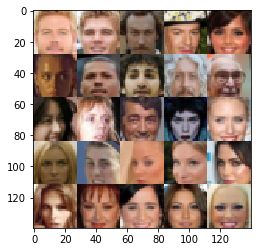

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="input_real")
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, (), name='learning_rate')
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [65]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # input: 28x28xchannels
        
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        bn1 = tf.layers.batch_normalization(conv1, training=True)
        relu1 = tf.maximum(alpha * conv1, conv1)
        # 14x14x64
        
        conv2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(conv2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        conv3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(conv3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256
        
        flat = tf.reshape(relu3, (-1, 4 * 4 * 256))
        logit = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logit)

        return output, logit


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [66]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        fc1 = tf.layers.dense(z, 7 * 7 * 512)
        proj1 = tf.reshape(fc1, (-1, 7, 7, 512))
        bn1 = tf.layers.batch_normalization(proj1, training=is_train)
        relu1 = tf.maximum(alpha * bn1, bn1)
        # 7x7x512
        
        deconv2 = tf.layers.conv2d_transpose(relu1, 256, 5, strides=1, padding='same')
        bn2 = tf.layers.batch_normalization(deconv2, training=is_train)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x256
        
        deconv3 = tf.layers.conv2d_transpose(relu2, 128, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(deconv3, training=is_train)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 14x14x128
        
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28xout_channel_dim
        
        output = tf.tanh(logits)
        
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [67]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    input_gen = generator(input_z, out_channel_dim)
    d_output_real, d_logit_real = discriminator(input_real)
    d_output_fake, d_logit_fake = discriminator(input_gen, reuse=True)

    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logit_real, labels=tf.ones_like(d_output_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logit_fake, labels=tf.zeros_like(d_output_fake)))

    d_loss = d_loss_real + d_loss_fake
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logit_fake, labels=tf.ones_like(d_output_fake)))

    return d_loss, g_loss    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [68]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [69]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [70]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    [_, image_width, image_height, image_channels] = data_shape
    input_real, input_z, _ = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1) 

    print_every = 10
    show_every = 100
    no_samples = 4
    
    i = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                i += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                sess.run(g_opt, feed_dict={input_z: batch_z})
                
                report_images = batch_images
                report_z = batch_z

                if i % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{}\t".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}\t".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if i % show_every == 0:
                    show_generator_output(sess, no_samples, input_z, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2	 Discriminator Loss: 0.9851	 Generator Loss: 0.7242
Epoch 1/2	 Discriminator Loss: 0.6635	 Generator Loss: 1.1786
Epoch 1/2	 Discriminator Loss: 2.3000	 Generator Loss: 0.1956
Epoch 1/2	 Discriminator Loss: 1.9446	 Generator Loss: 0.4082
Epoch 1/2	 Discriminator Loss: 1.0706	 Generator Loss: 1.0357
Epoch 1/2	 Discriminator Loss: 0.9280	 Generator Loss: 1.1885
Epoch 1/2	 Discriminator Loss: 1.4079	 Generator Loss: 0.5444
Epoch 1/2	 Discriminator Loss: 0.9708	 Generator Loss: 0.7833
Epoch 1/2	 Discriminator Loss: 0.9661	 Generator Loss: 1.4086
Epoch 1/2	 Discriminator Loss: 1.0755	 Generator Loss: 0.6321


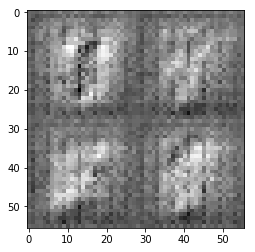

Epoch 1/2	 Discriminator Loss: 0.7846	 Generator Loss: 1.1535
Epoch 1/2	 Discriminator Loss: 0.6981	 Generator Loss: 1.8119
Epoch 1/2	 Discriminator Loss: 0.6369	 Generator Loss: 1.0239
Epoch 1/2	 Discriminator Loss: 0.4546	 Generator Loss: 1.6978
Epoch 1/2	 Discriminator Loss: 0.7357	 Generator Loss: 0.7752
Epoch 1/2	 Discriminator Loss: 0.4713	 Generator Loss: 1.3020
Epoch 1/2	 Discriminator Loss: 0.3803	 Generator Loss: 2.5767
Epoch 1/2	 Discriminator Loss: 0.8532	 Generator Loss: 3.5855
Epoch 1/2	 Discriminator Loss: 1.3959	 Generator Loss: 0.3323
Epoch 1/2	 Discriminator Loss: 1.2028	 Generator Loss: 0.4636


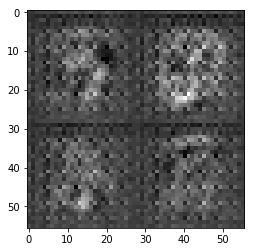

Epoch 1/2	 Discriminator Loss: 2.1947	 Generator Loss: 0.1464
Epoch 1/2	 Discriminator Loss: 1.5586	 Generator Loss: 0.4402
Epoch 1/2	 Discriminator Loss: 1.1144	 Generator Loss: 0.6429
Epoch 1/2	 Discriminator Loss: 1.1462	 Generator Loss: 0.6596
Epoch 1/2	 Discriminator Loss: 0.3655	 Generator Loss: 2.6874
Epoch 1/2	 Discriminator Loss: 0.8266	 Generator Loss: 2.2845
Epoch 1/2	 Discriminator Loss: 0.7078	 Generator Loss: 1.1218
Epoch 1/2	 Discriminator Loss: 0.4876	 Generator Loss: 1.2747
Epoch 1/2	 Discriminator Loss: 0.5133	 Generator Loss: 2.2336
Epoch 1/2	 Discriminator Loss: 0.4993	 Generator Loss: 1.4169


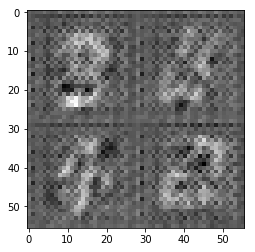

Epoch 1/2	 Discriminator Loss: 0.4111	 Generator Loss: 1.7052
Epoch 1/2	 Discriminator Loss: 0.4219	 Generator Loss: 1.5301
Epoch 1/2	 Discriminator Loss: 0.4765	 Generator Loss: 1.3769
Epoch 1/2	 Discriminator Loss: 0.4863	 Generator Loss: 1.3384
Epoch 1/2	 Discriminator Loss: 0.4555	 Generator Loss: 1.5028
Epoch 1/2	 Discriminator Loss: 0.4042	 Generator Loss: 2.5910
Epoch 1/2	 Discriminator Loss: 0.4096	 Generator Loss: 1.8158
Epoch 1/2	 Discriminator Loss: 0.3615	 Generator Loss: 2.2114
Epoch 1/2	 Discriminator Loss: 0.4424	 Generator Loss: 1.2954
Epoch 1/2	 Discriminator Loss: 0.4339	 Generator Loss: 1.3978


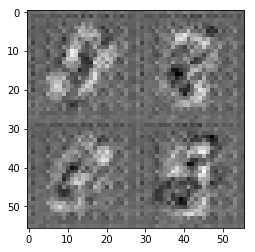

Epoch 1/2	 Discriminator Loss: 0.3226	 Generator Loss: 1.9096
Epoch 1/2	 Discriminator Loss: 0.3374	 Generator Loss: 1.8962
Epoch 1/2	 Discriminator Loss: 0.3292	 Generator Loss: 1.7316
Epoch 1/2	 Discriminator Loss: 0.2742	 Generator Loss: 2.1634
Epoch 1/2	 Discriminator Loss: 0.2514	 Generator Loss: 2.1729
Epoch 1/2	 Discriminator Loss: 0.5722	 Generator Loss: 3.4527
Epoch 2/2	 Discriminator Loss: 0.4651	 Generator Loss: 3.3186
Epoch 2/2	 Discriminator Loss: 0.2648	 Generator Loss: 2.1383
Epoch 2/2	 Discriminator Loss: 0.3001	 Generator Loss: 2.1512
Epoch 2/2	 Discriminator Loss: 1.1268	 Generator Loss: 0.4853


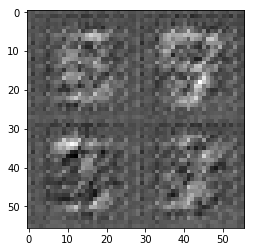

Epoch 2/2	 Discriminator Loss: 0.3233	 Generator Loss: 2.1058
Epoch 2/2	 Discriminator Loss: 0.2731	 Generator Loss: 2.2000
Epoch 2/2	 Discriminator Loss: 0.2819	 Generator Loss: 1.9886
Epoch 2/2	 Discriminator Loss: 0.2797	 Generator Loss: 2.2399
Epoch 2/2	 Discriminator Loss: 0.2581	 Generator Loss: 2.5996
Epoch 2/2	 Discriminator Loss: 0.2135	 Generator Loss: 2.2887
Epoch 2/2	 Discriminator Loss: 1.1245	 Generator Loss: 0.5903
Epoch 2/2	 Discriminator Loss: 0.2874	 Generator Loss: 2.1221
Epoch 2/2	 Discriminator Loss: 0.2672	 Generator Loss: 2.1265
Epoch 2/2	 Discriminator Loss: 0.2567	 Generator Loss: 2.1203


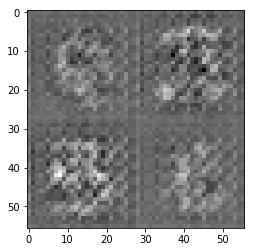

Epoch 2/2	 Discriminator Loss: 0.2238	 Generator Loss: 2.5546
Epoch 2/2	 Discriminator Loss: 0.2558	 Generator Loss: 2.0309
Epoch 2/2	 Discriminator Loss: 0.2084	 Generator Loss: 2.4244
Epoch 2/2	 Discriminator Loss: 1.1997	 Generator Loss: 5.2159
Epoch 2/2	 Discriminator Loss: 0.3513	 Generator Loss: 1.6754
Epoch 2/2	 Discriminator Loss: 0.2784	 Generator Loss: 2.0882
Epoch 2/2	 Discriminator Loss: 0.3300	 Generator Loss: 1.6696
Epoch 2/2	 Discriminator Loss: 0.1772	 Generator Loss: 2.7779
Epoch 2/2	 Discriminator Loss: 0.1742	 Generator Loss: 2.5972
Epoch 2/2	 Discriminator Loss: 0.1770	 Generator Loss: 2.6925


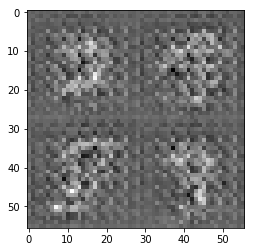

Epoch 2/2	 Discriminator Loss: 0.5522	 Generator Loss: 1.0340
Epoch 2/2	 Discriminator Loss: 0.2041	 Generator Loss: 2.3125
Epoch 2/2	 Discriminator Loss: 0.1991	 Generator Loss: 2.2384
Epoch 2/2	 Discriminator Loss: 0.3493	 Generator Loss: 1.8652
Epoch 2/2	 Discriminator Loss: 0.2522	 Generator Loss: 2.1720
Epoch 2/2	 Discriminator Loss: 0.2517	 Generator Loss: 2.0065
Epoch 2/2	 Discriminator Loss: 0.2258	 Generator Loss: 2.0849
Epoch 2/2	 Discriminator Loss: 0.2552	 Generator Loss: 1.9588
Epoch 2/2	 Discriminator Loss: 0.1741	 Generator Loss: 2.3165
Epoch 2/2	 Discriminator Loss: 0.1975	 Generator Loss: 2.3894


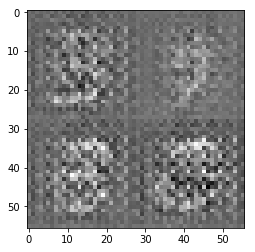

Epoch 2/2	 Discriminator Loss: 0.2232	 Generator Loss: 2.0160
Epoch 2/2	 Discriminator Loss: 0.1757	 Generator Loss: 2.4157
Epoch 2/2	 Discriminator Loss: 0.2691	 Generator Loss: 1.7971
Epoch 2/2	 Discriminator Loss: 0.6938	 Generator Loss: 3.8081
Epoch 2/2	 Discriminator Loss: 0.3559	 Generator Loss: 1.5173
Epoch 2/2	 Discriminator Loss: 0.3025	 Generator Loss: 1.7983
Epoch 2/2	 Discriminator Loss: 0.2506	 Generator Loss: 1.9883
Epoch 2/2	 Discriminator Loss: 0.2404	 Generator Loss: 2.0949
Epoch 2/2	 Discriminator Loss: 0.2384	 Generator Loss: 1.8876
Epoch 2/2	 Discriminator Loss: 0.2125	 Generator Loss: 2.0528


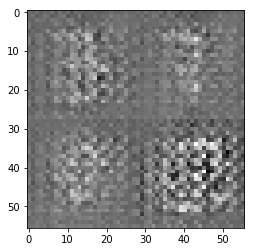

Epoch 2/2	 Discriminator Loss: 0.2033	 Generator Loss: 2.7218
Epoch 2/2	 Discriminator Loss: 0.1722	 Generator Loss: 2.3043
Epoch 2/2	 Discriminator Loss: 0.2729	 Generator Loss: 1.8333


In [71]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1	 Discriminator Loss: 1.7678	 Generator Loss: 0.4893
Epoch 1/1	 Discriminator Loss: 0.4755	 Generator Loss: 3.5592
Epoch 1/1	 Discriminator Loss: 0.7920	 Generator Loss: 1.1616
Epoch 1/1	 Discriminator Loss: 1.5870	 Generator Loss: 0.3680
Epoch 1/1	 Discriminator Loss: 0.6866	 Generator Loss: 1.7583
Epoch 1/1	 Discriminator Loss: 0.8488	 Generator Loss: 1.1740
Epoch 1/1	 Discriminator Loss: 0.5950	 Generator Loss: 1.4432
Epoch 1/1	 Discriminator Loss: 0.3345	 Generator Loss: 2.0624
Epoch 1/1	 Discriminator Loss: 0.2756	 Generator Loss: 2.2264
Epoch 1/1	 Discriminator Loss: 0.2740	 Generator Loss: 3.0570


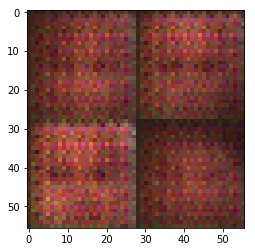

Epoch 1/1	 Discriminator Loss: 0.2803	 Generator Loss: 4.4676
Epoch 1/1	 Discriminator Loss: 0.2280	 Generator Loss: 2.3283
Epoch 1/1	 Discriminator Loss: 0.3224	 Generator Loss: 2.2140
Epoch 1/1	 Discriminator Loss: 0.9788	 Generator Loss: 4.7931
Epoch 1/1	 Discriminator Loss: 0.8034	 Generator Loss: 0.9221
Epoch 1/1	 Discriminator Loss: 2.0371	 Generator Loss: 0.1725
Epoch 1/1	 Discriminator Loss: 0.6419	 Generator Loss: 2.0691
Epoch 1/1	 Discriminator Loss: 0.5362	 Generator Loss: 3.2278
Epoch 1/1	 Discriminator Loss: 1.5137	 Generator Loss: 3.6372
Epoch 1/1	 Discriminator Loss: 0.3496	 Generator Loss: 2.1916


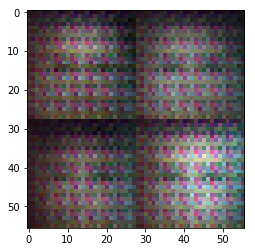

Epoch 1/1	 Discriminator Loss: 0.8993	 Generator Loss: 1.7928
Epoch 1/1	 Discriminator Loss: 1.3209	 Generator Loss: 1.2964
Epoch 1/1	 Discriminator Loss: 0.9019	 Generator Loss: 3.7756
Epoch 1/1	 Discriminator Loss: 0.8417	 Generator Loss: 0.7996
Epoch 1/1	 Discriminator Loss: 0.5128	 Generator Loss: 2.1499
Epoch 1/1	 Discriminator Loss: 0.8294	 Generator Loss: 0.9146
Epoch 1/1	 Discriminator Loss: 1.0793	 Generator Loss: 0.5767
Epoch 1/1	 Discriminator Loss: 0.8241	 Generator Loss: 0.7840
Epoch 1/1	 Discriminator Loss: 0.4145	 Generator Loss: 4.0939
Epoch 1/1	 Discriminator Loss: 0.2777	 Generator Loss: 2.1438


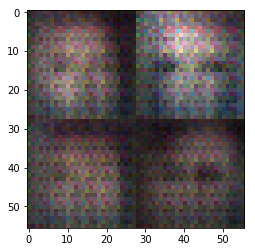

Epoch 1/1	 Discriminator Loss: 0.2374	 Generator Loss: 3.4947
Epoch 1/1	 Discriminator Loss: 0.5381	 Generator Loss: 1.2726
Epoch 1/1	 Discriminator Loss: 0.3332	 Generator Loss: 3.4905
Epoch 1/1	 Discriminator Loss: 0.3074	 Generator Loss: 5.0314
Epoch 1/1	 Discriminator Loss: 1.3006	 Generator Loss: 0.3962
Epoch 1/1	 Discriminator Loss: 0.4789	 Generator Loss: 3.2271
Epoch 1/1	 Discriminator Loss: 1.3318	 Generator Loss: 0.3605
Epoch 1/1	 Discriminator Loss: 0.1316	 Generator Loss: 5.7796
Epoch 1/1	 Discriminator Loss: 0.2278	 Generator Loss: 1.9357
Epoch 1/1	 Discriminator Loss: 2.2085	 Generator Loss: 0.2170


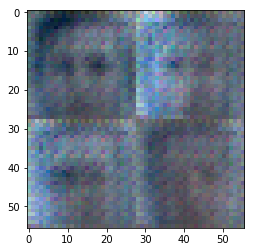

Epoch 1/1	 Discriminator Loss: 0.5227	 Generator Loss: 6.5566
Epoch 1/1	 Discriminator Loss: 0.1297	 Generator Loss: 3.9384
Epoch 1/1	 Discriminator Loss: 2.5779	 Generator Loss: 4.1603
Epoch 1/1	 Discriminator Loss: 0.1529	 Generator Loss: 7.0094
Epoch 1/1	 Discriminator Loss: 0.1294	 Generator Loss: 7.5510
Epoch 1/1	 Discriminator Loss: 0.0641	 Generator Loss: 7.3509
Epoch 1/1	 Discriminator Loss: 0.2279	 Generator Loss: 2.4053
Epoch 1/1	 Discriminator Loss: 0.1580	 Generator Loss: 5.0515
Epoch 1/1	 Discriminator Loss: 0.2063	 Generator Loss: 6.1018
Epoch 1/1	 Discriminator Loss: 0.0693	 Generator Loss: 5.7272


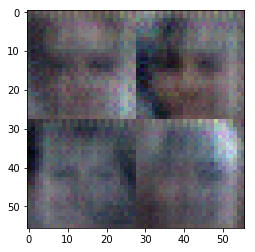

Epoch 1/1	 Discriminator Loss: 0.0241	 Generator Loss: 7.4766
Epoch 1/1	 Discriminator Loss: 0.1243	 Generator Loss: 3.0145
Epoch 1/1	 Discriminator Loss: 0.4505	 Generator Loss: 1.4919
Epoch 1/1	 Discriminator Loss: 0.4321	 Generator Loss: 1.3889
Epoch 1/1	 Discriminator Loss: 0.1171	 Generator Loss: 3.3083
Epoch 1/1	 Discriminator Loss: 0.9946	 Generator Loss: 0.6212
Epoch 1/1	 Discriminator Loss: 0.1555	 Generator Loss: 2.6074
Epoch 1/1	 Discriminator Loss: 0.0853	 Generator Loss: 3.8844
Epoch 1/1	 Discriminator Loss: 0.1717	 Generator Loss: 8.7170
Epoch 1/1	 Discriminator Loss: 0.2700	 Generator Loss: 2.3559


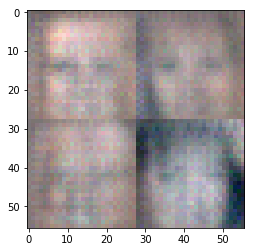

Epoch 1/1	 Discriminator Loss: 0.0184	 Generator Loss: 6.2955
Epoch 1/1	 Discriminator Loss: 0.0616	 Generator Loss: 7.3317
Epoch 1/1	 Discriminator Loss: 0.4331	 Generator Loss: 1.2504
Epoch 1/1	 Discriminator Loss: 0.0278	 Generator Loss: 5.8698
Epoch 1/1	 Discriminator Loss: 0.0267	 Generator Loss: 8.3962
Epoch 1/1	 Discriminator Loss: 0.1571	 Generator Loss: 4.6323
Epoch 1/1	 Discriminator Loss: 0.0525	 Generator Loss: 5.8253
Epoch 1/1	 Discriminator Loss: 0.0394	 Generator Loss: 5.5336
Epoch 1/1	 Discriminator Loss: 0.0609	 Generator Loss: 4.4030
Epoch 1/1	 Discriminator Loss: 0.0674	 Generator Loss: 4.9040


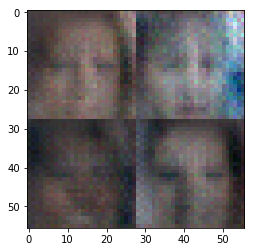

Epoch 1/1	 Discriminator Loss: 0.0343	 Generator Loss: 4.6227
Epoch 1/1	 Discriminator Loss: 0.0251	 Generator Loss: 6.1498
Epoch 1/1	 Discriminator Loss: 0.1644	 Generator Loss: 11.7833
Epoch 1/1	 Discriminator Loss: 0.0292	 Generator Loss: 7.7398
Epoch 1/1	 Discriminator Loss: 0.0270	 Generator Loss: 6.9166
Epoch 1/1	 Discriminator Loss: 0.0255	 Generator Loss: 8.9647
Epoch 1/1	 Discriminator Loss: 0.0454	 Generator Loss: 5.3219
Epoch 1/1	 Discriminator Loss: 0.0258	 Generator Loss: 9.4601
Epoch 1/1	 Discriminator Loss: 0.0272	 Generator Loss: 10.8906
Epoch 1/1	 Discriminator Loss: 0.0228	 Generator Loss: 9.2406


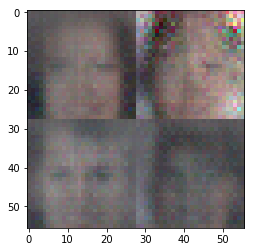

Epoch 1/1	 Discriminator Loss: 0.0419	 Generator Loss: 5.9766
Epoch 1/1	 Discriminator Loss: 0.0250	 Generator Loss: 5.0670
Epoch 1/1	 Discriminator Loss: 0.0195	 Generator Loss: 10.5332
Epoch 1/1	 Discriminator Loss: 0.0209	 Generator Loss: 4.8095
Epoch 1/1	 Discriminator Loss: 0.1051	 Generator Loss: 2.6203
Epoch 1/1	 Discriminator Loss: 0.0138	 Generator Loss: 7.9151
Epoch 1/1	 Discriminator Loss: 0.0301	 Generator Loss: 8.0895
Epoch 1/1	 Discriminator Loss: 0.1215	 Generator Loss: 2.5552
Epoch 1/1	 Discriminator Loss: 0.0113	 Generator Loss: 7.5256
Epoch 1/1	 Discriminator Loss: 0.0138	 Generator Loss: 8.2811


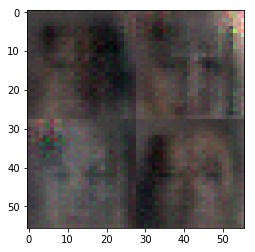

Epoch 1/1	 Discriminator Loss: 0.0175	 Generator Loss: 5.9264
Epoch 1/1	 Discriminator Loss: 0.1312	 Generator Loss: 8.7663
Epoch 1/1	 Discriminator Loss: 0.0194	 Generator Loss: 9.9413
Epoch 1/1	 Discriminator Loss: 0.0148	 Generator Loss: 7.0838
Epoch 1/1	 Discriminator Loss: 0.0239	 Generator Loss: 4.9102
Epoch 1/1	 Discriminator Loss: 0.4706	 Generator Loss: 1.2621
Epoch 1/1	 Discriminator Loss: 0.1703	 Generator Loss: 2.4041
Epoch 1/1	 Discriminator Loss: 0.9452	 Generator Loss: 0.5893
Epoch 1/1	 Discriminator Loss: 0.0167	 Generator Loss: 9.6649
Epoch 1/1	 Discriminator Loss: 0.0426	 Generator Loss: 5.6018


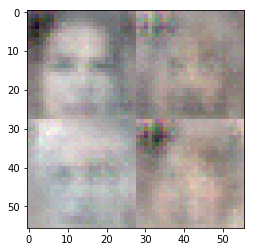

Epoch 1/1	 Discriminator Loss: 0.0145	 Generator Loss: 5.9985
Epoch 1/1	 Discriminator Loss: 0.1986	 Generator Loss: 2.1746
Epoch 1/1	 Discriminator Loss: 0.0959	 Generator Loss: 3.0155
Epoch 1/1	 Discriminator Loss: 0.0352	 Generator Loss: 10.8407
Epoch 1/1	 Discriminator Loss: 0.0130	 Generator Loss: 8.5544
Epoch 1/1	 Discriminator Loss: 0.1102	 Generator Loss: 2.7055
Epoch 1/1	 Discriminator Loss: 0.0294	 Generator Loss: 8.4253
Epoch 1/1	 Discriminator Loss: 0.0334	 Generator Loss: 7.6292
Epoch 1/1	 Discriminator Loss: 0.5152	 Generator Loss: 9.8711
Epoch 1/1	 Discriminator Loss: 0.0105	 Generator Loss: 8.8597


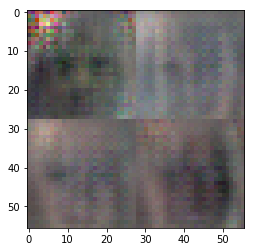

Epoch 1/1	 Discriminator Loss: 0.1197	 Generator Loss: 2.7087
Epoch 1/1	 Discriminator Loss: 0.1219	 Generator Loss: 10.1711
Epoch 1/1	 Discriminator Loss: 0.6747	 Generator Loss: 7.3470
Epoch 1/1	 Discriminator Loss: 0.0501	 Generator Loss: 5.3489
Epoch 1/1	 Discriminator Loss: 0.0047	 Generator Loss: 7.2225
Epoch 1/1	 Discriminator Loss: 0.9584	 Generator Loss: 0.7475
Epoch 1/1	 Discriminator Loss: 0.0613	 Generator Loss: 4.0284
Epoch 1/1	 Discriminator Loss: 0.0334	 Generator Loss: 9.7105
Epoch 1/1	 Discriminator Loss: 0.6072	 Generator Loss: 1.0333
Epoch 1/1	 Discriminator Loss: 0.0106	 Generator Loss: 8.4918


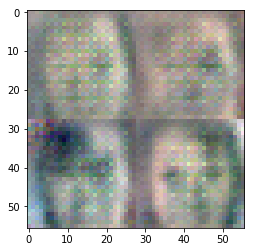

Epoch 1/1	 Discriminator Loss: 0.0756	 Generator Loss: 3.5282
Epoch 1/1	 Discriminator Loss: 0.0393	 Generator Loss: 7.7505
Epoch 1/1	 Discriminator Loss: 0.0556	 Generator Loss: 3.9420
Epoch 1/1	 Discriminator Loss: 0.0102	 Generator Loss: 7.8567
Epoch 1/1	 Discriminator Loss: 0.0337	 Generator Loss: 8.5883
Epoch 1/1	 Discriminator Loss: 0.0052	 Generator Loss: 7.9063
Epoch 1/1	 Discriminator Loss: 0.0295	 Generator Loss: 6.2313
Epoch 1/1	 Discriminator Loss: 0.0129	 Generator Loss: 6.8302
Epoch 1/1	 Discriminator Loss: 0.0094	 Generator Loss: 9.3061
Epoch 1/1	 Discriminator Loss: 0.0129	 Generator Loss: 8.7114


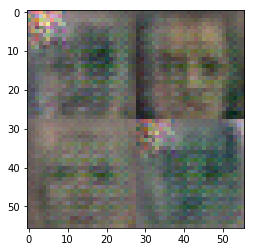

Epoch 1/1	 Discriminator Loss: 0.0284	 Generator Loss: 5.3744
Epoch 1/1	 Discriminator Loss: 0.0145	 Generator Loss: 6.9406
Epoch 1/1	 Discriminator Loss: 0.0387	 Generator Loss: 4.7513
Epoch 1/1	 Discriminator Loss: 0.0401	 Generator Loss: 5.3180
Epoch 1/1	 Discriminator Loss: 0.0941	 Generator Loss: 6.6391
Epoch 1/1	 Discriminator Loss: 0.0231	 Generator Loss: 6.6178
Epoch 1/1	 Discriminator Loss: 0.0380	 Generator Loss: 5.2324
Epoch 1/1	 Discriminator Loss: 0.0424	 Generator Loss: 7.0856
Epoch 1/1	 Discriminator Loss: 0.0524	 Generator Loss: 5.4471
Epoch 1/1	 Discriminator Loss: 0.0839	 Generator Loss: 9.6153


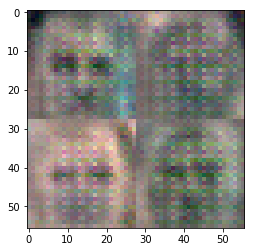

Epoch 1/1	 Discriminator Loss: 0.1122	 Generator Loss: 2.7699
Epoch 1/1	 Discriminator Loss: 0.0095	 Generator Loss: 9.1255
Epoch 1/1	 Discriminator Loss: 0.1476	 Generator Loss: 2.4835
Epoch 1/1	 Discriminator Loss: 0.0554	 Generator Loss: 5.9434
Epoch 1/1	 Discriminator Loss: 0.4227	 Generator Loss: 3.1146
Epoch 1/1	 Discriminator Loss: 0.2232	 Generator Loss: 6.2991
Epoch 1/1	 Discriminator Loss: 0.0368	 Generator Loss: 4.9115
Epoch 1/1	 Discriminator Loss: 0.4847	 Generator Loss: 1.3371
Epoch 1/1	 Discriminator Loss: 0.0316	 Generator Loss: 6.4918
Epoch 1/1	 Discriminator Loss: 0.1890	 Generator Loss: 5.8997


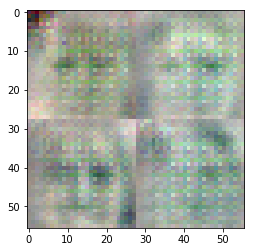

Epoch 1/1	 Discriminator Loss: 0.0115	 Generator Loss: 9.7163
Epoch 1/1	 Discriminator Loss: 0.0669	 Generator Loss: 3.9159
Epoch 1/1	 Discriminator Loss: 0.2976	 Generator Loss: 9.6049
Epoch 1/1	 Discriminator Loss: 0.0258	 Generator Loss: 7.8053
Epoch 1/1	 Discriminator Loss: 0.1869	 Generator Loss: 7.6162
Epoch 1/1	 Discriminator Loss: 0.0122	 Generator Loss: 5.9226
Epoch 1/1	 Discriminator Loss: 0.8608	 Generator Loss: 0.6274
Epoch 1/1	 Discriminator Loss: 0.1043	 Generator Loss: 2.7543


In [75]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.